In [21]:
import numpy as np
import matplotlib.pyplot as plt

# windy gridworld environment
class windyGridworld:
    def __init__(self):
        self.rows = 7
        self.cols = 10
        self.start = (3, 0)
        self.goal = (3, 7)
        self.wind = [0,0,0,1,1,1,2,2,1,0]
        self.reset()

    def reset(self):
        self.state = self.start
        return self.state

    def step(self, action):
        r, c = self.state

        # up down left right
        moves = {
            0: (-1, 0),
            1: ( 1, 0),
            2: ( 0,-1),
            3: ( 0, 1)
        }

        dr, dc = moves[action]
        nr = r + dr
        nc = c + dc
        nr -= self.wind[c]
        nr = max(0, min(nr, self.rows - 1))
        nc = max(0, min(nc, self.cols - 1))
        self.state = (nr, nc)
        reward = -1
        done = (self.state == self.goal)
        return self.state, reward, done


# choose random action with e, otherwise best action
class greedyPolicy:
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
    def select_action(self, Q, state):
        r, c = state
        if np.random.rand() < self.epsilon:
            return np.random.randint(4)
        return np.argmax(Q[r, c, :])


# on-policy td control to learn Q(s,a)
class sarsaAgent:
    def __init__(self, alpha=0.5, gamma=1.0, rows=7, cols=10):
        self.alpha = alpha
        self.gamma = gamma
        self.Q = np.zeros((rows, cols, 4))

    def update(self, state, action, reward, next_state, next_action):
        r, c = state
        nr, nc = next_state
        td_target = reward + self.gamma * self.Q[nr, nc, next_action]
        td_error  = td_target - self.Q[r, c, action]
        self.Q[r, c, action] += self.alpha * td_error


# training loop for sarsa
def train_sarsa(env, agent, policy, max_episodes=170):
    time_steps = 0
    episode_lengths = []
    for ep in range(max_episodes):
        # initialize S and choose A from S
        state = env.reset()
        action = policy.select_action(agent.Q, state)
        while True:
            # take A, observe R, S'
            next_state, reward, done = env.step(action)
            # choose A' from S'
            next_action = policy.select_action(agent.Q, next_state)
            # update Q(S,A)
            agent.update(state, action, reward, next_state, next_action)
            # S <- S' , A <- A'
            state, action = next_state, next_action
            time_steps += 1
            if done:  # S is terminal
                break
        episode_lengths.append(time_steps)
    return episode_lengths

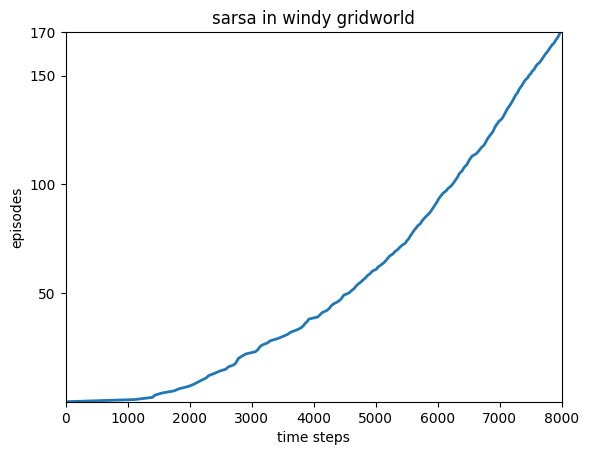

In [22]:
env = windyGridworld()
policy = greedyPolicy(epsilon=0.1)
agent = sarsaAgent(alpha=0.5, gamma=1.0)

data = train_sarsa(env, agent, policy, max_episodes=170)

plt.plot([0] + data, range(len(data) + 1), linewidth=2)

plt.xlim(0, 8000)
plt.ylim(0, 170)
plt.yticks([50, 100, 150, 170])
plt.xlabel("time steps")
plt.ylabel("episodes")
plt.title("sarsa in windy gridworld")
plt.show()